In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os
import numpy as np
import numpyro.distributions as dist
from jax import random

import seaborn as sns
import matplotlib.pyplot as plt
# Plots
plt.style.use('seaborn-whitegrid')

# PLOT PREAMBLE: LIKE LATEX
LATEX_WIDTH = 6
LATEX_HEIGHT = 3.24

SCRIPT_SIZE = 7

#Direct input
plt.rcParams['text.latex.preamble']=r"\usepackage{lmodern}"
#Options
params = {'text.usetex' : True,
          'font.size' : SCRIPT_SIZE,
          'axes.labelsize' : SCRIPT_SIZE,
          'xtick.labelsize' : SCRIPT_SIZE,
          'ytick.labelsize' : SCRIPT_SIZE,
          'legend.fontsize' : SCRIPT_SIZE,
          'figure.titlesize' : SCRIPT_SIZE,
          'font.family' : 'serif',
          'font.serif': ['Computer Modern Roman']
          }
plt.rcParams.update(params)


if not os.path.exists('figs/log_vol'):
    os.makedirs('figs/log_vol')

### Get samples

In [2]:
# pi_G
gibbs_thetas_vb_diag = np.load('../res/volatility/vb_diag.npy').squeeze()
gibbs_thetas_vb_full = np.load('../res/volatility/vb_full.npy').squeeze()
gibbs_thetas_mcmc_short = np.load('../res/volatility/mcmc_short_10.npy').squeeze()
gibbs_thetas_mcmc = np.load('../res/volatility/mcmc.npy').squeeze()

# Samples from the true prior
# Hyperparams
rng_key = random.PRNGKey(42)
sigma = 0.09
nu = 12
num_steps = gibbs_thetas_mcmc.shape[1]

rng_key, rng_subkey = random.split(rng_key)
thetas_prior = dist.GaussianRandomWalk(scale=sigma, num_steps=num_steps).sample(rng_subkey, (10000,))

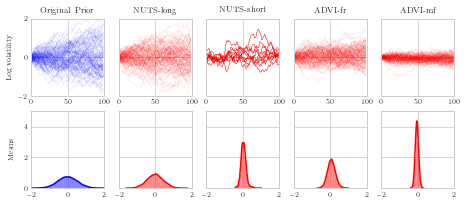

In [6]:
colors = ['blue'] + ['red'] * 4
dsets_full = [thetas_prior, gibbs_thetas_mcmc, gibbs_thetas_mcmc_short, gibbs_thetas_vb_full, gibbs_thetas_vb_diag]


num_samples = 100
dsets = [dset[::int(len(dset) / num_samples), :] for dset in dsets_full]
labels = [r'Original Prior', r'NUTS-long', r'NUTS-short', r'ADVI-fr', 'ADVI-mf']

fig, axs = plt.subplots(nrows=2, ncols=len(dsets))
fig.set_size_inches(LATEX_WIDTH, .4*LATEX_WIDTH)
plt.subplots_adjust(top = .99, bottom=.01, left=.01, right=.99, hspace=.2, wspace=.2)
legend_elements = []

# Choose random rows of posterior samples to avoid correlation of the chain
T = thetas_prior.shape[1]
rows = np.arange(100)
np.random.shuffle(rows)


for j in range(len(dsets)):
    # Plot time-series
    for i in rows[:100]:
        axs[0, j].plot(np.arange(T), dsets[j][i], ls="-", c=colors[j], alpha=0.2, lw=.3)
        axs[0, j].set_ylim((-2, 2))
        axs[0, j].set_xlim((0, 100))
        axs[0, j].set_xticks([0, 50, 100])
        axs[0, j].set_title(labels[j])
    axs[0, j].set_yticks([-2, 0, 2])
    if j != 0:
        axs[0, j].set_yticklabels([])
    else:
        axs[0, j].set_ylabel('Log volatility')
    # Plot means
    sns.histplot(dsets_full[j].mean(1), stat='density', kde=True, color=colors[j], ax=axs[1, j], edgecolor="white",
                 linewidth=.1, binwidth=.1)
    axs[1, j].set_xlim((-2, 2))
    axs[1, j].set_ylim((0, 5))

    axs[1, j].set_yticks([0, 2, 4])
    if j != 0:
        axs[1, j].set_ylabel('')
        axs[1, j].set_yticklabels([])
    else:
        axs[1, j].set_yticklabels([0, 2, 4])
        axs[1, j].set_ylabel('Means', labelpad=9)
# plt.tight_layout()
plt.savefig('../fig/timeseries_summary.pdf', bbox_inches='tight')
plt.show()